# Conversational Search - Phase 2

---
- André Bastos, nº 56969
- Carolina Goldstein, nº 57213
- Rafaela Cruz, nº 56926
---

## Imports

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pprint as pprint
from sklearn.feature_extraction.text import CountVectorizer
import json
import csv

import ElasticSearchSimpleAPI as es
elastic = es.ESSimpleAPI()

import TRECCASTeval_TEST as trec
# Create test bed object
test_bed = trec.ConvSearchEvaluation()

from bert_serving.client import BertClient
from sklearn.metrics.pairwise import cosine_similarity
from pandas.io.json import json_normalize

# BERT as a service
bc = BertClient()
bc.length_limit = 512


## Learning to rank - TRAIN

For this phase of the project, we used "Learning to rank". Using a machine learning technique, we learn a function to automatically rank results effectively. In this case, we used logistic regression and to do so we trained a logistic regression classifier, available in `sklearn`, using as training set the pairs of questions and passages, with their respective relevance judgments provided in `TRECCASTeval`. The trained logistic regression model provides the weights for each sentence pair embedding. These weights will then be used in the test set to rank the results. 

#### Preparation of training data to pass as input for the classifier

In [13]:
# Get relevance judgments from training set
train = test_bed.relevance_judgments

# Create a dictionary with the topic turn id and the utterance of each query
dic = {}
for topic in test_bed.train_topics:
    conv_id = topic['number']  
    for turn in topic['turn']:
        turn_id = turn['number']
        utterance = turn['raw_utterance']
        dic[f"{conv_id}_{turn_id}"]=utterance

# We only want the passages retrieved from MS MARCO
clean_train = train[train['docid'].str.contains('MARCO')]

# Create an empty dataframe to store the results
df_train = pd.DataFrame(columns=['Query', 'Passage', 'rel'])

# Store in the dataframe every passage retrieved for each query and the respective relevance judgment
for index, row in clean_train.iterrows():
    try:
        docid=row['docid']
        es_doc = elastic.client.get(index="msmarco", id=docid)
        query_text = dic[row['topic_turn_id']]

        df_train = df_train.append({'Query': query_text, 'Passage': es_doc["_source"]["body"], 'rel': row['rel']},ignore_index=True)  
    
    except:
        continue                                               

# Concatenate each passage with each query, using ' ||| ' as separator
texts = df_train["Query"] + " ||| " + df_train["Passage"]

# BERT embedding encoding
vects = bc.encode(texts.to_list(), is_tokenized=False)

# Turn the relevance judgments column in the training set to a numpy array
relevance = df_train["rel"].to_numpy()

#### Stratification of training data, by relevance judgement (relevant and non-relevant)

Because there are more non-relevant passages than relevant ones, we need to compute the weight to assign to each class, based on the frequency of each in our training data. This is done to avoid the classifier from becoming biased and classifying too many passages as non-relevant. 

Furthermore, the relevance judgments in the training data consist of multiple classes, and not only binary, but in our model we only want to classify passages as relevant or non-relevant. Therefore, for this stratification we transformed all relevance judgements over 1 in 1.

In [14]:
# Stratify sample based on whether examples are relevant or not - to use in class_weight

# Count the number of non-relevant and relevant passages  
count_relevant = np.count_nonzero(relevance)
count_nonrelevant = np.size(relevance,0) - count_relevant
print(count_relevant)
print(count_nonrelevant)

#Compute the weight to give to each class
relevant_weight = round(count_relevant/np.size(relevance,0),2)
nonrelevant_weight = round(1 - relevant_weight,2)
print(relevant_weight)
print(nonrelevant_weight)

# Class weights
class_weigths={0:nonrelevant_weight, 1:relevant_weight}

517
1018
0.34
0.66


#### Weight assignment to training data observations (query/passages)

Although we only want to classify passages as relevant or non-relevant, if a passage is considered more relevant than other, even if both are relevant, the first one should be given more emphasis to. To do so, we assigned a weight equal to the relevance to every observation. This allows a passage with a relevance judgement of 2, for instance, to count twice for the classifier. Of course observations with relevance judgement 0 (non-relevant) cannot get the same treatment, otherwise they would not be at all considered, so we assigned these observations the weight of 1. 

In [15]:
# Give more weight to query-passages that are more relevant - to use in sample_weight
relevance_4 = sum(relevance==4)
relevance_3 = sum(relevance==3)
relevance_2 = sum(relevance==2)
relevance_1 = sum(relevance==1)
print(relevance_4)
print(relevance_3)
print(relevance_2)
print(relevance_1)

# There are passages with a relevance of 2, so that passages need to have a greater weight. To do that, we will consider
# these passage to have a weight of 2, while the passages with a relevance of 0 or 1 will have a weight of 1
sample_weights = np.copy(relevance)
sample_weights[sample_weights == 0] = 1

0
0
270
247


#### Training the classification model

Having the training data prepared as input for the classifier, the weights for each class and observation determined, we trained the logistic regression classification model. We saved the weights, that will then be used in the test data.

In [16]:
# Train learning to rank model (logistic Regression)
from sklearn.linear_model import LogisticRegression

relevance = np.asarray(df_train["rel"]).astype('int')
# Transform relevance judgments in binary: relevant or non relevant
relevance_binary = np.copy(relevance)
relevance_binary[relevance_binary == 2] = 1

# Fit logistic regression using the class weights and the sample weights computed before
logistic = LogisticRegression(class_weight=class_weigths)
logistic.fit(vects,relevance_binary,sample_weights)

# Get the weights that will be used in the next steps of the project
w = logistic.coef_
print(w)

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[ 1.60534781e-01 -3.89427200e-01  4.53965420e-01  8.39740967e-03
   5.48909100e-01 -1.25860299e-01  3.01553503e-01 -2.98427845e-01
   5.56235458e-01  1.84330885e-01 -3.28341570e-01  7.36280909e-01
   3.45409678e-01 -1.03389676e-01  8.95825288e-02  1.23439263e+00
  -4.86235084e-02 -7.78494737e-01  3.91995758e-02 -1.02511392e-01
   1.99743233e-01  5.72648536e-01 -3.70752142e-01 -2.79743742e-01
  -3.64145392e-01  4.08564038e-02 -1.87275574e-02  5.26142319e-01
  -3.65972153e-03 -7.07800135e-01  5.10154216e-01 -2.75772602e-01
   7.12252355e-02  6.31585838e-01 -2.57905044e-01 -3.38221093e-01
   4.44019734e-02 -3.72303142e-01  2.80541021e-02 -7.79550634e-03
  -3.59985593e-02 -1.54829473e-01 -1.91533501e-01  4.28917804e-01
   2.73456398e-01  1.98224640e-02  5.52380048e-01 -5.38308960e-01
  -1.64941742e-01  8.31773383e-02  6.76782003e-02 -1.35464387e-01
  -1.82557452e-02  6.02904216e-01  4.07105544e-01  1.26471875e-02
  -3.67066246e-02 -1.40245388e-01 -5.85829920e-01 -3.39707154e-01
   6.39022

## Test Pipeline - TEST

### LMD

First, we need to get the results using only LMD (base). We export the results to an excel file, so we can analyse them later.

In [17]:
# Export to excel columns
columns_Elastic_turn = ["P10", "Recall", "Topic", "Turn", "Query"]
columns_Elastic_topic = ["Mean P10", "Mean Recall", "Mean AP", "Mean NDCG5", "Topic"]

# Export to excel dataframes
df_excel_turn = pd.DataFrame(columns = columns_Elastic_turn)
df_excel_topic = pd.DataFrame(columns = columns_Elastic_topic)

# Dict for elastic search results storing
results = {}

# For each topic, get p10, recall, ap and ndcg5 for each turn in it
for topic in test_bed.test_topics:
    # Variables for statistics storing
    topic_p10=[]
    topic_recall=[]
    topic_ap=[]
    topic_ndcg5=[]
    
    conv_id = topic['number']
    
    results[conv_id] = {}
    
    # Iterate each turn for the topic
    for turn in topic['turn']:
        turn_id = turn['number']
        utterance = turn['raw_utterance']
        topic_turn_id = f"{conv_id}_{turn_id}"
        
        # Get elastic search results for this query
        result = elastic.search_body(query=utterance, numDocs=100)
        # Store results in memory
        results[conv_id][turn_id] = result
        # Ignore empty results
        if result.empty:
            continue

        # Get p10, recall, ap and ndcg5 for this turn
        [p10, recall, ap, ndcg5] = test_bed.eval(result[['_id','_score']], topic_turn_id)
        
        # Store p10, recall, ap and ndcg5
        topic_p10.append(p10)
        topic_recall.append(recall)
        topic_ap.append(ap)
        topic_ndcg5.append(ndcg5)
        
        # Export to excel per turn
        list_stats = [p10, recall, conv_id, turn_id, utterance]
        df_excel_turn = df_excel_turn.append(pd.Series(list_stats, index = columns_Elastic_turn), ignore_index=True)
    
    # Get the means of p10, recall, ap and ndcg5 for the topics
    p10_mean = np.mean(topic_p10)
    recall_mean = np.mean(topic_recall)
    ap_mean = np.mean(topic_ap)
    ndcg5_mean = np.mean(topic_ndcg5)
    
    print (f"Topic: {conv_id}, P10 = {round(p10_mean,3)}, Recall = {round(recall_mean,3)}, AP = {round(ap_mean,3)}, NDCG5 = {round(ndcg5,3)}")
        
    # Export to excel per topic
    list_stats_topic = [p10_mean, recall_mean, ap_mean, ndcg5_mean, topic["number"]]
    df_excel_topic = df_excel_topic.append(pd.Series(list_stats_topic, index = columns_Elastic_topic), ignore_index=True)
    
df_excel_topic.to_excel("LMD_Base.xlsx")

Topic: 31, P10 = 0.322, Recall = 0.178, AP = 0.1, NDCG5 = 0.0
Topic: 32, P10 = 0.318, Recall = 0.24, AP = 0.117, NDCG5 = 0.0
Topic: 33, P10 = 0.089, Recall = 0.041, AP = 0.028, NDCG5 = 0.0
Topic: 34, P10 = 0.078, Recall = 0.023, AP = 0.016, NDCG5 = 0.0
Topic: 35, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 36, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 37, P10 = 0.15, Recall = 0.071, AP = 0.062, NDCG5 = 0.0
Topic: 38, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 39, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 40, P10 = 0.07, Recall = 0.031, AP = 0.006, NDCG5 = 0.0
Topic: 41, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 42, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 43, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 44, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 45, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 46, P10 = 0.0, Recall = 0.0, AP = 0.0, NDCG5 = 0.0
Topic: 47, P10 = 0.0, Recall = 0.0, AP = 

### RM3 + LMD with expanded queries

Afterwards, we create a new function to expand the queries using RM3. The expanded queries are sent to Elastic Search, where LMD is used to compute the new results.

In [18]:
# This cell has the RM3 execution for a query
# We saw in the Mini-Project that the best alpha was between 0.1 and 0.5 to emphasize precision
def get_query_expanded(query = "What is a physician's assistant?", alpha = 0.5, threshold = 0.5, number_best_docs = 3, numDocs=100):
    elastic = es.ESSimpleAPI()
    
    # Note that we are not using the results obtained above for convenience, in case we want to use only this function,
    # without runnig the cell above
    result = elastic.search_body(query, numDocs=numDocs)

    try:
        list_of_documents = result["_id"].to_list()
    except: return 
    doc_freq, sum_doc_freq, sum_ttf, docs_term_vectors = elastic.multi_doc_term_vectors(list_of_documents)

    # Get scores for documents
    docs_scores = []
    for doc in docs_term_vectors:
        doc_score = result.loc[result['_id'] == doc]["_score"].to_list()[0]
        docs_scores.append(doc_score)

    # Normalize scores
    #docs_scores_normalized = (docs_scores - np.min(docs_scores))/(np.max(docs_scores) - np.min(docs_scores))
    docs_scores_normalized = docs_scores
    # Order scores by doc _id
    scores_ordered = []
    scores_pd = pd.DataFrame(list(zip(docs_term_vectors.keys(), docs_scores_normalized)), columns =['_id', 'score'])
    scores_ordered = scores_pd.sort_values(by=['score'], ascending=False)

    # Value of the best documents to consider
    #number_best_docs

    # Choose the best documents
    best_scores = scores_ordered.iloc[0:number_best_docs,]

    # Get probability of term in doc for terms in best docs
    # This probabilities_terms_in_docs has for each term of best doc the probability of the term in the document
    probabilities_terms_in_docs = {}
    for doc_row in best_scores.iterrows():
        doc_id = doc_row[1]["_id"]
        probabilities_terms_in_docs[doc_id] = []

        terms_list = docs_term_vectors[doc_id]

        # Get frequencies of all words in the doc
        all_frequencies_words_in_doc = 0
        for term in terms_list.keys():
            # stats has term_frequency, doc_frequency, total_frequency_of_word_in_corpus
            stats = terms_list[term]
            all_frequencies_words_in_doc += stats[0]

        # Calculate the probability of terms in the document
        for term in terms_list.keys():
            stats = terms_list[term]
            probability_term_doc = stats[0] / all_frequencies_words_in_doc
            probabilities_terms_in_docs[doc_id].append({"term": term, "prob": probability_term_doc})

    # Calculate RM1 for every term
    RM1s_per_term = {}
    for doc in probabilities_terms_in_docs.keys():
        #Document Score
        score_doc = best_scores.loc[best_scores['_id'] == doc, "score"].item()
        for term_row in probabilities_terms_in_docs[doc]:
            if term_row["term"] not in RM1s_per_term.keys():
                RM1s_per_term[term_row["term"]] = term_row["prob"] * score_doc
            else:
                RM1s_per_term[term_row["term"]] += term_row["prob"] * score_doc

    # Normalize RM1s
    RM1s = []
    RM1_terms = []
    for row in RM1s_per_term.items():
        RM1s.append(row[1])
        RM1_terms.append(row[0])
    RM1s_normalized = (RM1s - np.min(RM1s))/(np.max(RM1s) - np.min(RM1s))
    RM1_pd = pd.DataFrame(list(zip(RM1_terms, RM1s_normalized)), columns =['term', 'rm1'])

    # Get query as an array of terms
    query_items = elastic.query_terms(query, "rebuilt_english").strip().split(" ")

    # Calculate probs of terms in Query
    length_query = len(query_items)
    freqs_terms_query = {}
    # Get frequencies of terms in the query
    for word in query_items:
        if word in freqs_terms_query.keys():
            freqs_terms_query[word] += 1
        else:
            freqs_terms_query[word] = 1
    probs_terms_query = {}
    # Get probabilities of the terms in the query
    for word in freqs_terms_query.keys():
        probs_terms_query[word] = freqs_terms_query[word]/length_query

    # Get RM3
    RM3s_per_term = {}
    # Calculate RM3 for terms already in the original query
    for word in probs_terms_query.keys():
        # Get collection score for rm3
        corpus_score = 0
        try:
            corpus_score = RM1_pd.loc[RM1_pd['term'] == word, "rm1"].item()
        except:
            # If can't find item throws an error but the value stays 0 so it's fine
            if False: print("couldn't find")
        # Apply RM3 formula
        RM3s_per_term[word] = (1 - alpha) * probs_terms_query[word] + alpha * corpus_score

    # Calculate RM3 for terms of the corpus that were not in the query
    # Needs only to calculate the last part of RM3 formula since probability of term in the query will always be 0
    for index, row in RM1_pd.iterrows():
        if row["term"] not in RM3s_per_term.keys():
            RM3s_per_term[row["term"]] = alpha * row["rm1"]

    # Establish the threshold that will select the worthy terms to include in the expanded query
    # threshold
    # Filter terms based on the threshold above
    filtered_RM3 = {k: v for k, v in RM3s_per_term.items() if v > threshold}

    # Get the expanded query in the required formate to be sent to Elastic search with term boosting
    expanded_query = ""
    for term in filtered_RM3.keys():
        # Had to sum 1 to rm3 score to make it impossible to fall between 0 an 1 because it makes the opposite of boosting
        expanded_query += term + "^" + str(round(filtered_RM3[term],2) + 1) + " "
    expanded_query = expanded_query[0:len(expanded_query)-1]
    
    # Go to elastic search for LMD
    try:
        query_qsl = {"query": {"match": {"body": expanded_query}}}
    except ErrorName:
        print("ERROR IN ELASTIC :", ErrorName)
    new_lmd_result = elastic.search_QSL(query_qsl, 100)

    return new_lmd_result

In [19]:
new_lmds = {}
# Iterate each topic
for topic in test_bed.test_topics:
    conv_id = topic['number']
    new_lmds[conv_id] = {}
    
    # Iterate each turn for the topic
    for turn in topic['turn']:
        turn_id = turn['number']
        print(f"Topic: {conv_id}, Turn: {turn_id}")
        utterance = turn['raw_utterance']
        
        try:
            new_lmds[conv_id][turn_id] = get_query_expanded(query = utterance, alpha = 0.5, threshold = 0.5)
        except NameError:
            print("ERROR: ", NameError)       

Topic: 31, Turn: 1


/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `item` has been deprecated and will be removed in a future version
/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:101: FutureWarning: `item` has been deprecated and will be removed in a future version


Topic: 31, Turn: 2
Topic: 31, Turn: 3
Topic: 31, Turn: 4
Topic: 31, Turn: 5
Topic: 31, Turn: 6
Topic: 31, Turn: 7
Topic: 31, Turn: 8
Topic: 31, Turn: 9
Topic: 32, Turn: 1
Topic: 32, Turn: 2
Topic: 32, Turn: 3
Topic: 32, Turn: 4
Topic: 32, Turn: 5
Topic: 32, Turn: 6
Topic: 32, Turn: 7
Topic: 32, Turn: 8
Topic: 32, Turn: 9
Topic: 32, Turn: 10
Topic: 32, Turn: 11
Topic: 33, Turn: 1
Topic: 33, Turn: 2
Topic: 33, Turn: 3
Topic: 33, Turn: 4
Topic: 33, Turn: 5
Topic: 33, Turn: 6
Topic: 33, Turn: 7
Topic: 33, Turn: 8
Topic: 33, Turn: 9
Topic: 33, Turn: 10
Topic: 34, Turn: 1
Topic: 34, Turn: 2
Topic: 34, Turn: 3
Topic: 34, Turn: 4
Topic: 34, Turn: 5
Topic: 34, Turn: 6
Topic: 34, Turn: 7
Topic: 34, Turn: 8
Topic: 34, Turn: 9
Topic: 35, Turn: 1
Topic: 35, Turn: 2
Topic: 35, Turn: 3
Topic: 35, Turn: 4
Topic: 35, Turn: 5
Topic: 35, Turn: 6
Topic: 35, Turn: 7
Topic: 35, Turn: 8
Topic: 35, Turn: 9
Topic: 36, Turn: 1
Topic: 36, Turn: 2
Topic: 36, Turn: 3
Topic: 36, Turn: 4
Topic: 36, Turn: 5
Topic: 36

### BERT

After getting the results with LMD, using Elastic Search, we store every passage returned for each query in a dataframe, as well as the topic turn id and the passage id, which will be used when computing the metrics for the results.

In [20]:
# To facilitate the BERT encoding step, we create a function that returns a dataframe every passage for each turn
def query_passage_df(results):
    df_test_queries = pd.DataFrame(columns=['Topic_Turn_Id','Query','Passages'])
    no_results = []

    for topic in test_bed.test_topics:
        conv_id = topic['number']  
        for turn in topic['turn']:
            turn_id = turn['number']
            topic_turn_id = f'{conv_id}_{turn_id}'
            utterance = turn['raw_utterance']
            
            # Append every passage retrieved for each query
            try:
                result_query = results[conv_id][turn_id].loc[ : , '_source.body' ]
                result_docid = results[conv_id][turn_id].loc[ : , '_id' ]
                for index, value in result_query.items():
                    df_test_queries = df_test_queries.append({'Topic_Turn_Id': topic_turn_id, '_id':result_docid[index], 'Query': utterance, 'Passages': value},ignore_index=True)
                    
            # There are turns for which there are no results, so we do not add them to the dataframe
            except:              
                no_results.append(f"{conv_id}_{turn_id}")
    
    print(f"Turns for which no results were found:{no_results}")
    return df_test_queries

#### BERT for LMD

First, we create the dataframe for the results obtained with LMD only, before the query expansion. Then, we concatenate each query with each passage, using a ' ||| ' as a separator. We can use the concatenated query + passage to compute the sentence-pair embeddings using BERT trained on MS MARCO.

In [21]:
# Create dataframe for results obtained using only LMD
lmd_df = query_passage_df(results)

Turns for which no results were found:['33_2', '50_9', '66_6', '71_12']


In [22]:
lmd_df

Topic_Turn_Id                                   Query  \
0              31_1                  What is throat cancer?   
1              31_1                  What is throat cancer?   
2              31_1                  What is throat cancer?   
3              31_1                  What is throat cancer?   
4              31_1                  What is throat cancer?   
...             ...                                     ...   
47316         80_10  What was the impact of the expedition?   
47317         80_10  What was the impact of the expedition?   
47318         80_10  What was the impact of the expedition?   
47319         80_10  What was the impact of the expedition?   
47320         80_10  What was the impact of the expedition?   

                                                Passages            _id  
0      There are two main types of throat cancer: Squ...  MARCO_3878348  
1      This type of throat cancer is the most common ...   MARCO_191050  
2      Types of throat cancer. Throat cancer is a gen...  MARCO_8610842  
3      Throat cancer refers to cancerous tumors that ...  MARCO_3090847  
4      What is throat cancer? Throat cancer is any ca...   MARCO_789620  
...                                                  ...            ...  
47316  Used Ford Expedition Models The current, third...   MARCO_778939  
47317  expedition. 1  an excursion, journey, or voyag...   MARCO_835644  
47318  Lewis and Clark Expedition, (1804â06), U.S. ...   MARCO_666437  
47319  Members of the expedition were remarkably reso...   MARCO_666440  
47320  The purpose of the Lewis and Clark Trail Herit...  MARCO_2172156  

[47321 rows x 4 columns]

In [23]:
# Concatenate each query to each passage
texts = lmd_df["Query"] + " ||| " + lmd_df["Passages"]
# Compute BERT embedding encoding for results obtained using only LMD
vects = bc.encode(texts.to_list(), is_tokenized=False)

#### BERT for RM3 + LMD

We do the same for the results obtained using RM3.

In [24]:
# Create dataframe for results obtained using RM3 + LMD
rm3_df = query_passage_df(new_lmds)

Turns for which no results were found:['33_2', '40_9', '42_3', '46_10', '50_9', '56_8', '62_8', '66_6', '68_3', '71_12', '72_1', '77_4']


In [25]:
rm3_df

Topic_Turn_Id                                   Query  \
0              31_1                  What is throat cancer?   
1              31_1                  What is throat cancer?   
2              31_1                  What is throat cancer?   
3              31_1                  What is throat cancer?   
4              31_1                  What is throat cancer?   
...             ...                                     ...   
46619         80_10  What was the impact of the expedition?   
46620         80_10  What was the impact of the expedition?   
46621         80_10  What was the impact of the expedition?   
46622         80_10  What was the impact of the expedition?   
46623         80_10  What was the impact of the expedition?   

                                                Passages            _id  
0      Planet good for another 1.75 billion years, sc...  MARCO_3202587  
1      There are two main types of throat cancer: Squ...  MARCO_3878348  
2      This type of throat cancer is the most common ...   MARCO_191050  
3      Types of throat cancer. Throat cancer is a gen...  MARCO_8610842  
4      Throat cancer refers to cancerous tumors that ...  MARCO_3090847  
...                                                  ...            ...  
46619  The dimensions for a Supreme box logo are roug...  MARCO_6300475  
46620  The other option is paying $12.95 a month, whi...  MARCO_8504195  
46621  Here are the varieties of ice cream being reca...  MARCO_3006110  
46622  How many tablespoons in 1.75 ounce of dry pect...  MARCO_1721653  
46623  Will Hayden net worth: $1.75 Million Will Hayd...  MARCO_2980439  

[46624 rows x 4 columns]

In [26]:
# Concatenate each query to each passage
texts_rm3 = rm3_df["Query"] + " ||| " + rm3_df["Passages"]
# Compute BERT embedding encoding for results obtained using RM3 + LMD
vects_rm3 = bc.encode(texts_rm3.to_list(), is_tokenized=False)

### Scores (using Learning to Rank)

After obtaining the sentence-pair embeddings, we use the vector with the weights obtained with logistic regression in the training step (w) to compute the scores for every passage retrieved.

In [27]:
# Compute the scores for the documents retrieved in LMD
scores = np.dot(vects, np.transpose(w))
scores_df = pd.DataFrame(data=scores,columns=["Scores"])

# Concatenate the scores with the topic turn id and the document id, to use to compute the metrics
concatenated = pd.concat([lmd_df['Topic_Turn_Id'],lmd_df['_id'],scores_df],axis=1)
concatenated.sort_values(['Topic_Turn_Id', 'Scores'],ascending=[True,False])

Topic_Turn_Id            _id    Scores
11             31_1  MARCO_5990560  3.088809
97             31_1  MARCO_1331560  3.038827
23             31_1  MARCO_3990603  3.009571
5              31_1  MARCO_1373522  2.777599
9              31_1  MARCO_3878347  2.745694
...             ...            ...       ...
47211          80_9  MARCO_2013123 -3.463856
47210          80_9  MARCO_7159145 -3.889392
47214          80_9  MARCO_8034973 -4.629409
47199          80_9  MARCO_4046170 -5.214576
47163          80_9   MARCO_292291 -6.274006

[47321 rows x 3 columns]

In [28]:
# Compute the scores for the documents retrieved in LMD + RM3
scores_rm3 = np.dot(vects_rm3, np.transpose(w))
scores_rm3_df = pd.DataFrame(data=scores_rm3,columns=["Scores"])

# Concatenate the scores with the topic turn id and the document id, to use to compute the metrics
concatenated_rm3 = pd.concat([rm3_df['Topic_Turn_Id'],rm3_df['_id'],scores_rm3_df],axis=1)
concatenated_rm3.sort_values(['Topic_Turn_Id', 'Scores'],ascending=[True,False])

Topic_Turn_Id            _id    Scores
21             31_1  MARCO_5990560  3.088809
48             31_1  MARCO_3990603  3.009571
7              31_1  MARCO_1373522  2.777599
14             31_1  MARCO_3878347  2.745694
5              31_1   MARCO_789620  2.599880
...             ...            ...       ...
46478          80_9  MARCO_5418665 -3.573199
46480          80_9  MARCO_1124945 -3.742218
46485          80_9  MARCO_1458341 -4.127428
46519          80_9  MARCO_4046170 -5.214576
46467          80_9   MARCO_292291 -6.274006

[46624 rows x 3 columns]

## Evaluation

First we need to create a function to compute the metrics for the results obtained with BERT.

In [29]:
def get_metrics(dataframe, test_bed):
    metrics = {}
    last_topic = ""
    nr_topics = 0
    p10_array = []
    recall_array = []
    ap_array = []
    ndcg5_array = []
    for topic_turn_id in dataframe["Topic_Turn_Id"]:
        print("METRICS topic_turn_id", topic_turn_id)

        topic = topic_turn_id.split("_")[0]
        [p10, recall, ap, ndcg5] = test_bed.eval(dataframe.loc[dataframe['Topic_Turn_Id'] == topic_turn_id,['_id','Scores']], 
                                                 topic_turn_id)

        if last_topic == "": last_topic = topic
        if last_topic == topic:
            nr_topics += 1
            p10_array.append(p10)
            recall_array.append(recall)
            ap_array.append(ap)
            ndcg5_array.append(ndcg5)
        else:
            avg_p10 = sum(p10_array) / nr_topics
            avg_recall = sum(recall_array) / nr_topics
            avg_ap = sum(ap_array) / nr_topics
            avg_ndcg5 = sum(ndcg5_array) / nr_topics
            metrics[topic] = {"avg_p10":avg_p10, "avg_recall":avg_recall, "avg_ap":avg_ap, "avg_ndcg5":avg_ndcg5}
            last_topic = topic
            nr_topics = 1
            p10_array = [p10]
            recall_array = [recall]
            ap_array = [ap]
            ndcg5_array = [ndcg5]

    avg_p10 = sum(p10_array) / nr_topics
    avg_recall = sum(recall_array) / nr_topics
    avg_ap = sum(ap_array) / nr_topics
    avg_ndcg5 = sum(ndcg5_array) / nr_topics
    metrics[topic] = {"avg_p10":avg_p10, "avg_recall":avg_recall, "avg_ap":avg_ap, "avg_ndcg5":avg_ndcg5}
    
    return metrics

In [30]:
# Metrics for LMD
metrics_lmd = get_metrics(concatenated, test_bed)
metrics_lmd

METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
M

{'32': {'avg_p10': 0.32222222222222147,
  'avg_recall': 0.17765284404207698,
  'avg_ap': 0.09967356563763284,
  'avg_ndcg5': 0.22130696565683233},
 '33': {'avg_p10': 0.318181818181816,
  'avg_recall': 0.23983015583583656,
  'avg_ap': 0.1168808656603777,
  'avg_ndcg5': 0.2885689636014714},
 '34': {'avg_p10': 0.08888888888888871,
  'avg_recall': 0.04106280193236718,
  'avg_ap': 0.02758285776875429,
  'avg_ndcg5': 0.06455185381921091},
 '35': {'avg_p10': 0.07777777777777792,
  'avg_recall': 0.02347417840375587,
  'avg_ap': 0.016336997267203286,
  'avg_ndcg5': 0.08665515049281099},
 '36': {'avg_p10': 0.0, 'avg_recall': 0.0, 'avg_ap': 0.0, 'avg_ndcg5': 0.0},
 '37': {'avg_p10': 0.0, 'avg_recall': 0.0, 'avg_ap': 0.0, 'avg_ndcg5': 0.0},
 '38': {'avg_p10': 0.15000000000000052,
  'avg_recall': 0.07125660142901478,
  'avg_ap': 0.061556111200589986,
  'avg_ndcg5': 0.10636330705872447},
 '39': {'avg_p10': 0.0, 'avg_recall': 0.0, 'avg_ap': 0.0, 'avg_ndcg5': 0.0},
 '40': {'avg_p10': 0.0, 'avg_recall'

In [31]:
# Metrics for RM3
metrics_rm3 = get_metrics(concatenated_rm3, test_bed)

METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
M

We store the metrics as jsons:

In [32]:
with open('metrics_lmd', 'w') as fout:
    json.dump(metrics_lmd, fout)

In [33]:
with open('metrics_rm3', 'w') as fout:
    json.dump(metrics_rm3, fout)

Read from jsons:

In [34]:
# Metris for base LMD, without BERT
lmd_base = pd.read_excel("LMD_Base.xlsx", header=0, index_col=0)

In [35]:
# Metrics for LMD with BERT
with open('metrics_lmd') as json_file:
    lmd_metrics = json.load(json_file)
    json_file.close()
lmd_metrics = pd.DataFrame.from_dict(lmd_metrics, orient='index')

In [36]:
# Metrics for RM3 with BERT
with open('metrics_rm3') as json_file:
    rm3_metrics = json.load(json_file)
    json_file.close()
rm3_metrics = pd.DataFrame.from_dict(rm3_metrics, orient='index')

### Ploting the results

To better visualize the results, we are going to represent them in several plots, comparing the metrics and comparing the models with each other.

#### LMD base

Topics with metrics = 0: [35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 53, 55, 57, 60, 62, 63, 64, 65, 66, 70, 71, 72, 73, 74, 76, 80]


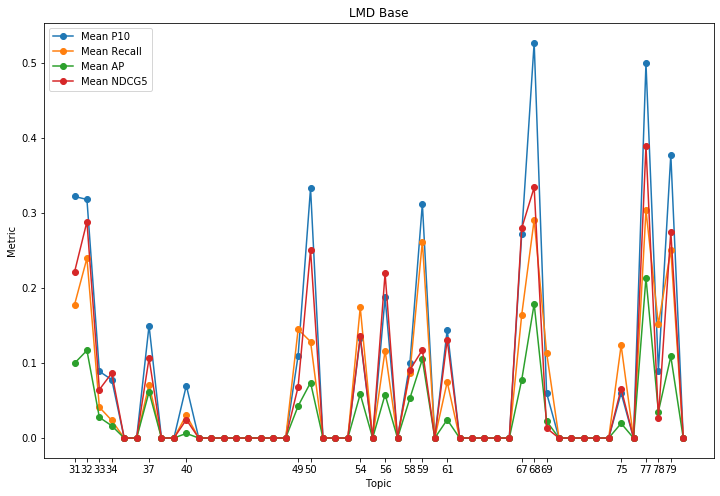

In [37]:
plt.figure(figsize=(12,8))
plt.plot(lmd_base["Topic"], lmd_base["Mean P10"],"-o")
plt.plot(lmd_base["Topic"], lmd_base["Mean Recall"],"-o")
plt.plot(lmd_base["Topic"], lmd_base["Mean AP"],"-o")
plt.plot(lmd_base["Topic"], lmd_base["Mean NDCG5"],"-o")
plt.xticks(lmd_base[lmd_base["Mean P10"]!=0]["Topic"])
plt.ylabel("Metric")
plt.xlabel("Topic")
plt.title("LMD Base")
plt.legend(["Mean P10", "Mean Recall", "Mean AP","Mean NDCG5"])

topics_0 = [i for i in lmd_base[lmd_base["Mean P10"]==0]["Topic"]]
print("Topics with metrics = 0:", topics_0)

#### LMD with BERT

Topics with metrics = 0: ['36', '37', '39', '40', '42', '43', '44', '45', '46', '47', '48', '49', '52', '53', '54', '56', '58', '61', '63', '64', '65', '66', '67', '71', '72', '73', '74', '75', '77', '80']


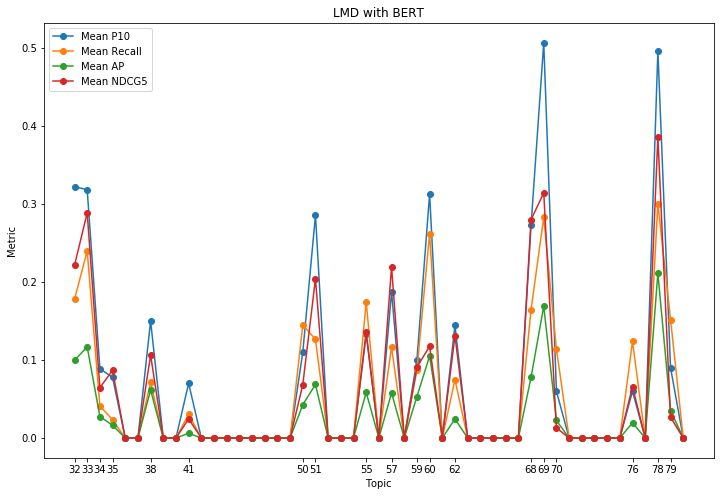

In [38]:
plt.figure(figsize=(12,8))
plt.plot(lmd_metrics.index, lmd_metrics["avg_p10"],"-o")
plt.plot(lmd_metrics.index, lmd_metrics["avg_recall"],"-o")
plt.plot(lmd_metrics.index, lmd_metrics["avg_ap"],"-o")
plt.plot(lmd_metrics.index, lmd_metrics["avg_ndcg5"],"-o")
plt.xticks(lmd_metrics[lmd_metrics["avg_p10"]!=0].index)
plt.ylabel("Metric")
plt.xlabel("Topic")
plt.title("LMD with BERT")
plt.legend(["Mean P10", "Mean Recall", "Mean AP","Mean NDCG5"])

topics_0 = [i for i in lmd_metrics[lmd_metrics["avg_p10"]==0].index]
print("Topics with metrics = 0:", topics_0)

#### RM3 with BERT

Topics with metrics = 0: ['35', '36', '37', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '52', '53', '54', '56', '58', '61', '63', '64', '65', '66', '67', '70', '71', '72', '73', '74', '75', '76', '77', '80']


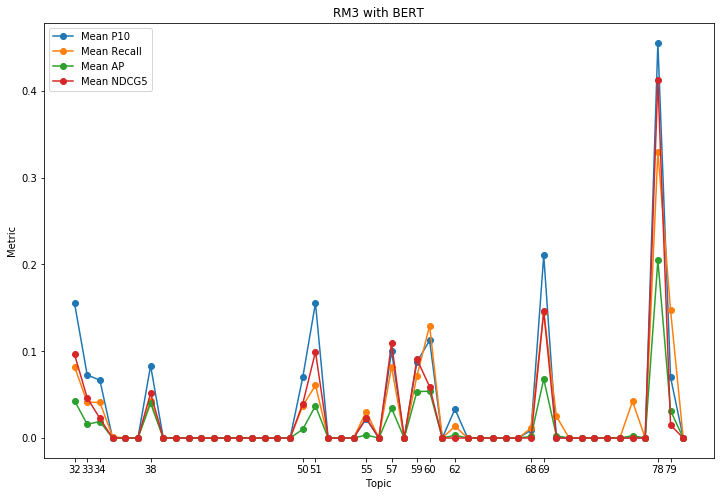

In [39]:
plt.figure(figsize=(12,8))
plt.plot(rm3_metrics.index, rm3_metrics["avg_p10"],"-o")
plt.plot(rm3_metrics.index, rm3_metrics["avg_recall"],"-o")
plt.plot(rm3_metrics.index, rm3_metrics["avg_ap"],"-o")
plt.plot(rm3_metrics.index, rm3_metrics["avg_ndcg5"],"-o")
plt.xticks(rm3_metrics[rm3_metrics["avg_p10"]!=0].index)
plt.ylabel("Metric")
plt.xlabel("Topic")
plt.title("RM3 with BERT")
plt.legend(["Mean P10", "Mean Recall", "Mean AP","Mean NDCG5"])

topics_0 = [i for i in rm3_metrics[rm3_metrics["avg_p10"]==0].index]
print("Topics with metrics = 0:", topics_0)

Observing all the plots above, we see that all the metrics seem to vary in the same way for each plot. We also see that there are several topics for which the all the metrics were zero. That means that for these topics no relevant documents were retrieved.

To better compare the results for each model, we can plot them in the same plot. Note that we will only be comparing the NDCG@5 and P@10 metrics, because our main concern is to have the most relevant passages retrieved in the first positions on the rank.

#### LMD base vs LMD with BERT

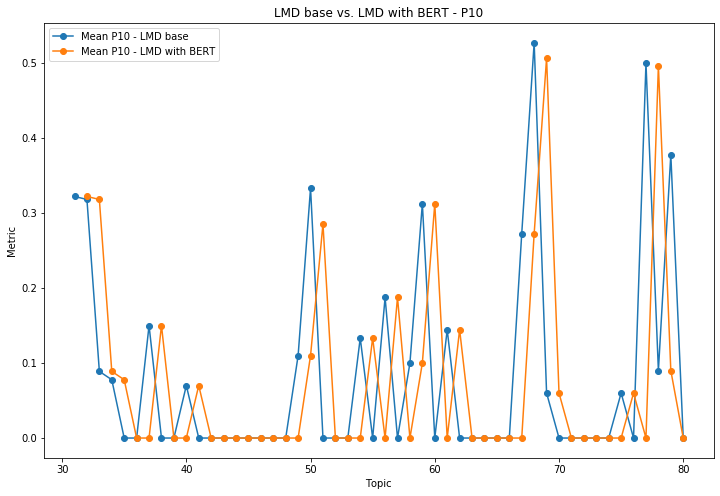

In [40]:
plt.figure(figsize=(12,8))
plt.plot([i for i in lmd_base["Topic"]], lmd_base["Mean P10"],"-o")
indexes_to_list = lmd_metrics.index.values.tolist()
indexes_to_list = [int(i) for i in indexes_to_list]
plt.plot(indexes_to_list, lmd_metrics["avg_p10"],"-o")

plt.ylabel("Metric")
plt.xlabel("Topic")
plt.title("LMD base vs. LMD with BERT - P10")

plt.legend(["Mean P10 - LMD base", "Mean P10 - LMD with BERT"])

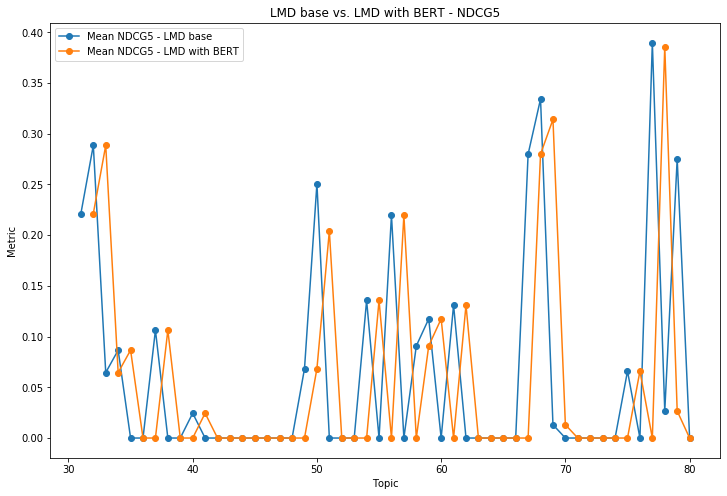

In [41]:
plt.figure(figsize=(12,8))
plt.plot([i for i in lmd_base["Topic"]], lmd_base["Mean NDCG5"],"-o")
indexes_to_list = lmd_metrics.index.values.tolist()
indexes_to_list = [int(i) for i in indexes_to_list]
plt.plot(indexes_to_list, lmd_metrics["avg_ndcg5"],"-o")

plt.ylabel("Metric")
plt.xlabel("Topic")
plt.title("LMD base vs. LMD with BERT - NDCG5")

plt.legend(["Mean NDCG5 - LMD base", "Mean NDCG5 - LMD with BERT"])

Observing the plots, we see that the results obtained with LMD using BERT do not differ from the base LMD. To show that, we plotted the lines out of phase.

This result was not expected, because we used the sentence-pair embeddings for LMD with BERT, and obtained the scores multiplying these sentence-pair embeddings by the weights computed using learning to rank. One possible reason for this is that the training set used was very small when compared to the test set, containing relevance judgments for around 1500 passages. Because of this inadequacy of the training set, the weights computed were not the most correct, and thus the results did not improve.

#### LMD vs RM3

Text(0.5, 0, 'Topic')

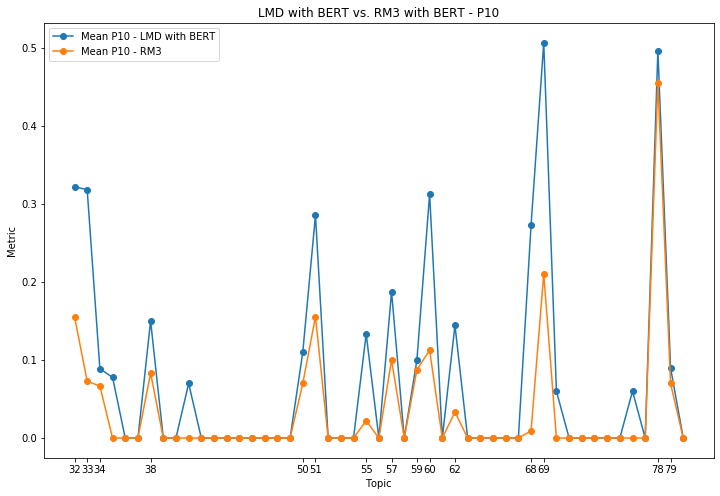

In [71]:
plt.figure(figsize=(12,8))
plt.plot(lmd_metrics.index, lmd_metrics["avg_p10"],"-o")
plt.plot(rm3_metrics.index, rm3_metrics["avg_p10"],"-o")
plt.legend(["Mean P10 - LMD with BERT", "Mean P10 - RM3"])
plt.xticks(rm3_metrics[rm3_metrics["avg_p10"]!=0].index)
plt.title("LMD with BERT vs. RM3 with BERT - P10")
plt.ylabel("Metric")
plt.xlabel("Topic")

Text(0.5, 0, 'Topic')

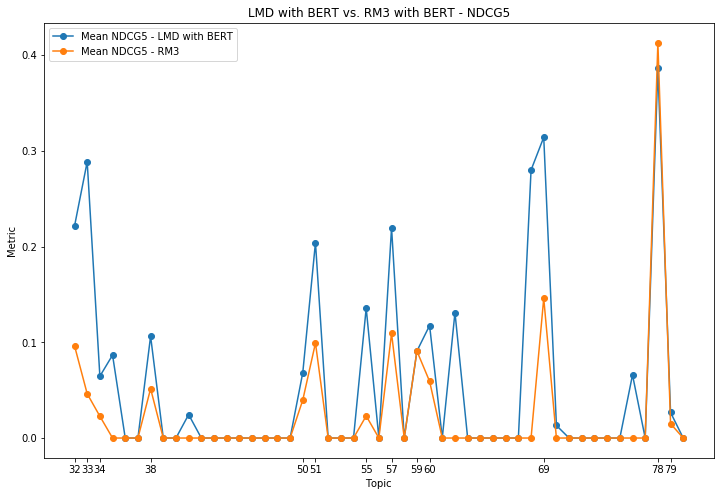

In [70]:
plt.figure(figsize=(12,8))
plt.plot(lmd_metrics.index, lmd_metrics["avg_ndcg5"],"-o")
plt.plot(rm3_metrics.index, rm3_metrics["avg_ndcg5"],"-o")
plt.legend(["Mean NDCG5 - LMD with BERT", "Mean NDCG5 - RM3"])
plt.xticks(rm3_metrics[rm3_metrics["avg_ndcg5"]!=0].index)
plt.title("LMD with BERT vs. RM3 with BERT - NDCG5")
plt.ylabel("Metric")
plt.xlabel("Topic")

Observing the comparison between the results obtained with LMD and with RM3, we see that the results for RM3 are worse in almost every case. This was also not expected, because in RM3 the queries are expanded with relevant terms, so the results should be better.

The results obtained with RM3 could possibly be improved if we had fine tuned the parameters of this model. However, these computations would take an unreasonable amount of time to execute, so we chose not to do this.

### Average Metrics Comparison

We can also compute the total average of the metrics for all topics, excluding the topics for which these metrics were zero.

In [44]:
# Average metrics for base LMD
lmd_base[lmd_base["Mean P10"]!=0].mean()

Mean P10        0.211798
Mean Recall     0.148586
Mean AP         0.070027
Mean NDCG5      0.159550
Topic          55.350000
dtype: float64

In [45]:
# Average metrics for LMD with BERT
lmd_metrics[lmd_metrics["avg_p10"]!=0].mean()

avg_p10       0.199269
avg_recall    0.142476
avg_ap        0.067060
avg_ndcg5     0.149745
dtype: float64

In [46]:
# Average metrics for RM3 with BERT
rm3_metrics[rm3_metrics["avg_p10"]!=0].mean()

avg_p10       0.113629
avg_recall    0.084439
avg_ap        0.041336
avg_ndcg5     0.080819
dtype: float64

Comparing the results, we see that, for all the metrics, the results were better for base LMD than for the other methods. These results did not differ much from LMD with BERT, as described before.

Comparing our results with the ones obtained in the *WaterlooClarke at the TREC 2019 Conversational Assistant Track* paper, in which the results for NDCG@5 varied from 0.3504 to 0.4059, our results were much worse.

Therefore, we decided to implement an Historical Query Expansion, based on the paper *Query and Answer Expansion from Conversation History*, to try to improve our results.

## Historical Query Expansion (HQE)

Historical Query Expansion refers to the concept of introducing query terms from previous turns in the next ones (in the same topic). This allows questions like "How much does it cost?" to be disambiguated and clarified, by relating it to the topic.

To make sure that the queries always preserve the topic and context, we preserve the query terms of the first turn to the rest of the turns for the rest of the conversation.

These query terms are appended after using query vectorization from ElasticSearch, including stemming, trimming and removal of stop words. 


Furthermore, for the rest of the conversation we preserve only the terms of the previous turn query to append to the current query, instead of the terms of all previous turns, to avoid adding too many terms to the query and worsening the retrieval.

### RM3 after HQE

First, we will implement the HQE and use the expanded queries in the complete pipeline: HQE - LMD - RM3 - LMD - BERT - Product by W.

#### RM3

In [47]:
new_rm3s_with_historical = {}
# Iterate each topic
for topic in test_bed.test_topics:
    conv_id = topic['number']
    new_rm3s_with_historical[conv_id] = {}
    first_turn_query_terms = []
    previous_turn_query_terms = []
    
    # Iterate each turn for the topic
    for turn in topic['turn']:
        turn_id = turn['number']
        print(f"Topic: {conv_id}, Turn: {turn_id}")
        utterance = turn['raw_utterance']
        new_utterance = utterance
        
        if turn_id == 1:
            first_turn_query_terms = elastic.query_terms(utterance, "rebuilt_english").strip().split(" ")
        else:
            # Expand with first query terms
            for term in first_turn_query_terms:
                new_utterance += " " + term
            # Expand with previous query terms
            for term in previous_turn_query_terms:
                new_utterance += " " + term
            previous_turn_query_terms = elastic.query_terms(utterance, "rebuilt_english").strip().split(" ")
            
        print("new_utterance", new_utterance)
        try:
            # Go get results for RM3
            new_rm3s_with_historical[conv_id][turn_id] = get_query_expanded(query = new_utterance, alpha = 0.5, threshold = 0.5)
        except NameError:
            print("ERROR: ", NameError)

Topic: 31, Turn: 1
new_utterance What is throat cancer?


/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:61: FutureWarning: `item` has been deprecated and will be removed in a future version
/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/ipykernel_launcher.py:101: FutureWarning: `item` has been deprecated and will be removed in a future version


Topic: 31, Turn: 2
new_utterance Is it treatable? throat cancer
Topic: 31, Turn: 3
new_utterance Tell me about lung cancer. throat cancer treat
Topic: 31, Turn: 4
new_utterance What are its symptoms?  throat cancer tell lung cancer
Topic: 31, Turn: 5
new_utterance Can it spread to the throat? throat cancer symptom
Topic: 31, Turn: 6
new_utterance What causes throat cancer? throat cancer spread throat
Topic: 31, Turn: 7
new_utterance What is the first sign of it? throat cancer cause throat cancer
Topic: 31, Turn: 8
new_utterance Is it the same as esophageal cancer? throat cancer sign
Topic: 31, Turn: 9
new_utterance What's the difference in their symptoms? throat cancer esophageal cancer
Topic: 32, Turn: 1
new_utterance What are the different types of sharks?
Topic: 32, Turn: 2
new_utterance Are sharks endangered?  If so, which species? different type shark
Topic: 32, Turn: 3
new_utterance Tell me more about tiger sharks. different type shark shark endanger species
Topic: 32, Turn: 4
ne

#### BERT

In [48]:
# Create dataframe for results obtained using HQE + RM3
rm3_hqe_df = query_passage_df(new_rm3s_with_historical)

Turns for which no results were found:['39_9', '40_7', '40_10', '42_7', '56_6', '57_7', '57_10', '58_5', '60_7', '62_8', '68_3', '68_7', '68_8', '68_11', '72_1', '74_8']


In [49]:
# Concatenate each query to each passage
texts_rm3_hqe = rm3_hqe_df["Query"] + " ||| " + rm3_hqe_df["Passages"]
# Compute BERT embedding encoding for results obtained using HQE + RM3
vects_rm3_hqe = bc.encode(texts_rm3_hqe.to_list(), is_tokenized=False)

#### Obtain scores

In [50]:
# Compute the scores for the documents retrieved in HQE + RM3
scores_rm3_hqe = np.dot(vects_rm3_hqe, np.transpose(w))
scores_rm3_hqe_df = pd.DataFrame(data=scores_rm3_hqe,columns=["Scores"])

# Concatenate the scores with the topic turn id and the document id, to use to compute the metrics
concatenated_rm3_hqe = pd.concat([rm3_hqe_df['Topic_Turn_Id'],rm3_hqe_df['_id'],scores_rm3_hqe_df],axis=1)
concatenated_rm3_hqe.sort_values(['Topic_Turn_Id', 'Scores'],ascending=[True,False])

Topic_Turn_Id            _id    Scores
21             31_1  MARCO_5990560  3.088809
48             31_1  MARCO_3990603  3.009571
7              31_1  MARCO_1373522  2.777599
14             31_1  MARCO_3878347  2.745694
5              31_1   MARCO_789620  2.599880
...             ...            ...       ...
46067          80_9  MARCO_6784745 -4.634031
46112          80_9   MARCO_578480 -4.944618
46056          80_9  MARCO_8756220 -5.254037
46047          80_9  MARCO_8185031 -5.343974
46096          80_9  MARCO_5542216 -5.768098

[46217 rows x 3 columns]

#### Compute metrics and store them in json file

In [51]:
# Metrics for HQE + RM3
metrics_rm3_hqe = get_metrics(concatenated_rm3_hqe, test_bed)

METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
M

In [52]:
# Store metrics of RM3 + Historical Expansion in json
with open('metrics_rm3_with_historical_expansion', 'w') as fout:
    json.dump(metrics_rm3_hqe, fout)

In [53]:
# Get metrics to a dataframe
with open('metrics_rm3_with_historical_expansion') as json_file:
    metrics_rm3_with_historical_expansion = json.load(json_file)
    json_file.close()
metrics_rm3_with_historical_expansion = pd.DataFrame.from_dict(metrics_rm3_with_historical_expansion, orient='index')

#### Plot the results for HQE + RM3

Topics with metrics = 0: ['35', '36', '37', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '52', '53', '54', '55', '56', '58', '61', '63', '64', '65', '66', '67', '68', '71', '72', '73', '74', '75', '76', '77', '80']


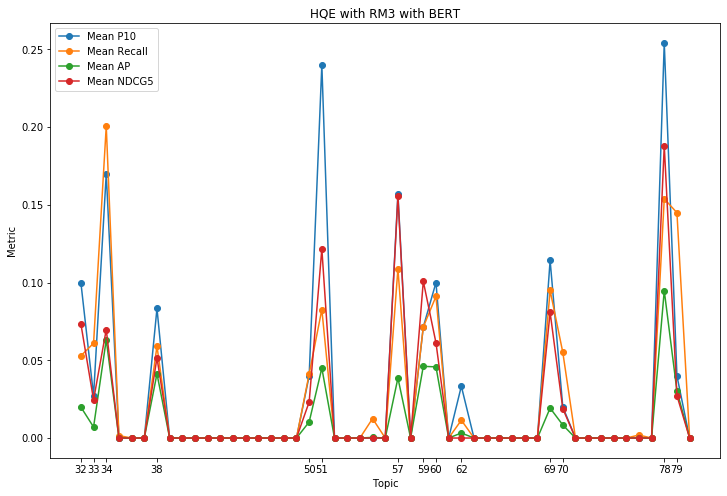

In [54]:
plt.figure(figsize=(12,8))
plt.plot(metrics_rm3_with_historical_expansion.index, metrics_rm3_with_historical_expansion["avg_p10"],"-o")
plt.plot(metrics_rm3_with_historical_expansion.index, metrics_rm3_with_historical_expansion["avg_recall"],"-o")
plt.plot(metrics_rm3_with_historical_expansion.index, metrics_rm3_with_historical_expansion["avg_ap"],"-o")
plt.plot(metrics_rm3_with_historical_expansion.index, metrics_rm3_with_historical_expansion["avg_ndcg5"],"-o")
plt.xticks(metrics_rm3_with_historical_expansion[metrics_rm3_with_historical_expansion["avg_p10"]!=0].index)
plt.ylabel("Metric")
plt.xlabel("Topic")
plt.title("HQE with RM3 with BERT")
plt.legend(["Mean P10", "Mean Recall", "Mean AP","Mean NDCG5"])

topics_0 = [i for i in metrics_rm3_with_historical_expansion[metrics_rm3_with_historical_expansion["avg_p10"]==0].index]
print("Topics with metrics = 0:", topics_0)

Just by observing this plot, we see that the results were not very good, because the P10, for example, has a maximum of 0.25, while in the plots without HQE, this metric reached 0.5. Nevertheless, we are going to compare these results to the ones obtained using only LMD, without HQE or RM3.

Text(0.5, 0, 'Topic')

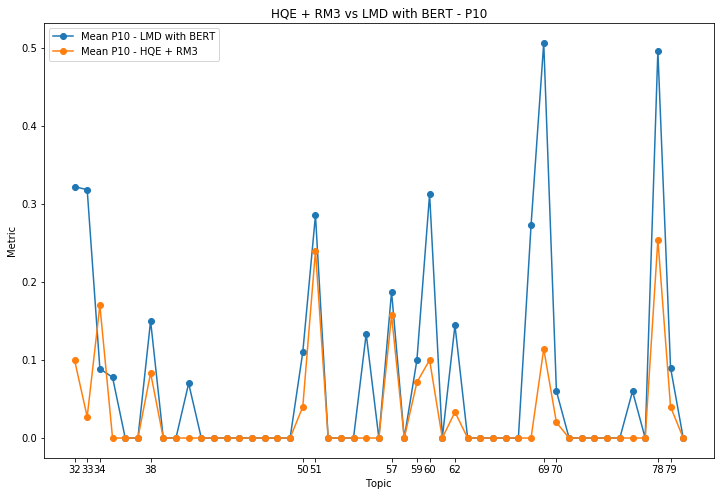

In [55]:
# Comparison of HQE + RM3 with LMD with BERT (since it had the best results)
plt.figure(figsize=(12,8))
plt.plot(lmd_metrics.index, lmd_metrics["avg_p10"],"-o")
plt.plot(metrics_rm3_with_historical_expansion.index, metrics_rm3_with_historical_expansion["avg_p10"],"-o")
plt.legend(["Mean P10 - LMD with BERT", "Mean P10 - HQE + RM3"])
plt.xticks(metrics_rm3_with_historical_expansion[metrics_rm3_with_historical_expansion["avg_p10"]!=0].index)
plt.title("HQE + RM3 vs LMD with BERT - P10")
plt.ylabel("Metric")
plt.xlabel("Topic")

Text(0.5, 0, 'Topic')

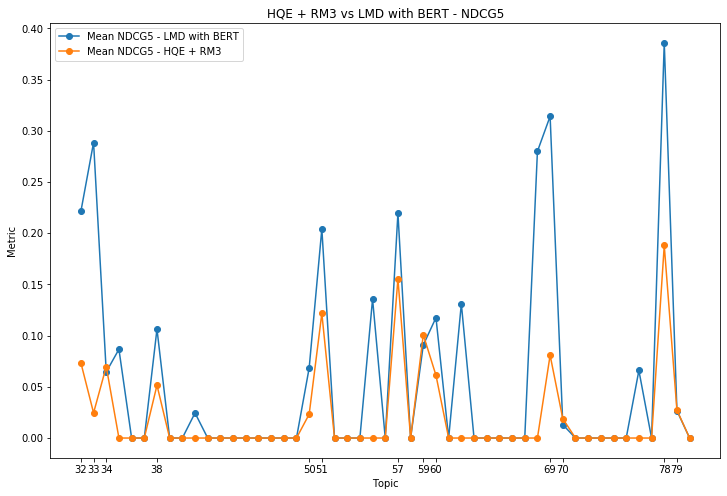

In [56]:
plt.figure(figsize=(12,8))
plt.plot(lmd_metrics.index, lmd_metrics["avg_ndcg5"],"-o")
plt.plot(metrics_rm3_with_historical_expansion.index, metrics_rm3_with_historical_expansion["avg_ndcg5"],"-o")
plt.legend(["Mean NDCG5 - LMD with BERT", "Mean NDCG5 - HQE + RM3"])
plt.xticks(metrics_rm3_with_historical_expansion[metrics_rm3_with_historical_expansion["avg_ndcg5"]!=0].index)
plt.title("HQE + RM3 vs LMD with BERT - NDCG5")
plt.ylabel("Metric")
plt.xlabel("Topic")

These results support our statements above: HQE + RM3 does not improve the results. Actually, it even worsens the P@10 and the NDCG@5 in almost every topic.

As we stated before, the parameters for RM3 are not fine tuned, and that could be the reason for these poor results. Furthermore, we are using expanded queries and expanding them even more. This could result in too long queries, which can be doing more harm than good.

Therefore, we decided to use HQE and study the results obtained using only LMD, without RM3. This is, we are going to follow the pipeline: HQE - LMD - BERT - Product by W.

### LMD after HQE

#### LMD

In [57]:
new_lmds_with_historical_without_rm3 = {}
# Iterate each topic
for topic in test_bed.test_topics:
    conv_id = topic['number']
    new_lmds_with_historical_without_rm3[conv_id] = {}
    first_turn_query_terms = []
    previous_turn_query_terms = []
    
    # Iterate each turn for the topic
    for turn in topic['turn']:
        turn_id = turn['number']
        print(f"Topic: {conv_id}, Turn: {turn_id}")
        utterance = turn['raw_utterance']
        new_utterance = utterance
        
        if turn_id == 1:
            first_turn_query_terms = elastic.query_terms(utterance, "rebuilt_english").strip().split(" ")
        else:
            # Expand with first query terms
            for term in first_turn_query_terms:
                new_utterance += " " + term
            # Expand with previous query terms
            for term in previous_turn_query_terms:
                new_utterance += " " + term
            previous_turn_query_terms = elastic.query_terms(utterance, "rebuilt_english").strip().split(" ")
            
        print("new_utterance", new_utterance)
        try:
            new_lmds_with_historical_without_rm3[conv_id][turn_id] = elastic.search_body(new_utterance, numDocs=100)
        except NameError:
            print("ERROR: ", NameError)       

Topic: 31, Turn: 1
new_utterance What is throat cancer?
Topic: 31, Turn: 2
new_utterance Is it treatable? throat cancer
Topic: 31, Turn: 3
new_utterance Tell me about lung cancer. throat cancer treat
Topic: 31, Turn: 4
new_utterance What are its symptoms?  throat cancer tell lung cancer
Topic: 31, Turn: 5
new_utterance Can it spread to the throat? throat cancer symptom
Topic: 31, Turn: 6
new_utterance What causes throat cancer? throat cancer spread throat
Topic: 31, Turn: 7
new_utterance What is the first sign of it? throat cancer cause throat cancer
Topic: 31, Turn: 8
new_utterance Is it the same as esophageal cancer? throat cancer sign
Topic: 31, Turn: 9
new_utterance What's the difference in their symptoms? throat cancer esophageal cancer
Topic: 32, Turn: 1
new_utterance What are the different types of sharks?
Topic: 32, Turn: 2
new_utterance Are sharks endangered?  If so, which species? different type shark
Topic: 32, Turn: 3
new_utterance Tell me more about tiger sharks. different

#### BERT

In [58]:
# Create dataframe for results obtained using LMD + Historical Expansion
lmd_hqe_df = query_passage_df(new_lmds_with_historical_without_rm3)

Turns for which no results were found:[]


In [59]:
# Concatenate each query to each passage
texts_lmd_hqe = lmd_hqe_df["Query"] + " ||| " + lmd_hqe_df["Passages"]
# Compute BERT embedding encoding for results obtained using LMD + Historical Expansion
vects_lmd_hqe = bc.encode(texts_lmd_hqe.to_list(), is_tokenized=False)

#### Obtain scores

In [60]:
# Compute the scores for the documents retrieved in RM3 + Historical Expansion
scores_lmd_hqe = np.dot(vects_lmd_hqe, np.transpose(w))
scores_lmd_hqe_df = pd.DataFrame(data=scores_lmd_hqe,columns=["Scores"])

# Concatenate the scores with the topic turn id and the document id, to use to compute the metrics
concatenated_lmd_hqe = pd.concat([lmd_hqe_df['Topic_Turn_Id'],lmd_hqe_df['_id'],scores_lmd_hqe_df],axis=1)
concatenated_lmd_hqe.sort_values(['Topic_Turn_Id', 'Scores'],ascending=[True,False])

Topic_Turn_Id            _id    Scores
11             31_1  MARCO_5990560  3.088809
97             31_1  MARCO_1331560  3.038827
23             31_1  MARCO_3990603  3.009571
5              31_1  MARCO_1373522  2.777599
9              31_1  MARCO_3878347  2.745694
...             ...            ...       ...
47799          80_9  MARCO_2703346 -0.407064
47718          80_9  MARCO_7736894 -0.740644
47723          80_9  MARCO_1016402 -0.826881
47732          80_9  MARCO_4410568 -2.337227
47734          80_9  MARCO_1619992 -3.362112

[47900 rows x 3 columns]

#### Compute metrics

In [61]:
# Metrics for LMD + Historical Expansion
metrics_lmd_hqe = get_metrics(concatenated_lmd_hqe, test_bed)

METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
METRICS topic_turn_id 31_1
M

In [62]:
# Store metrics of LMD + Historical Expansion in json
with open('metrics_lmd_with_historical_expansion', 'w') as fout:
    json.dump(metrics_lmd_hqe, fout)

In [63]:
# Get metrics to a dataframe
with open('metrics_lmd_with_historical_expansion') as json_file:
    metrics_lmd_with_historical_expansion = json.load(json_file)
    json_file.close()
metrics_lmd_with_historical_expansion = pd.DataFrame.from_dict(metrics_lmd_with_historical_expansion, orient='index')

#### Plot the results for HQE + LMD

Topics with metrics = 0: ['36', '37', '39', '40', '42', '43', '44', '45', '46', '47', '48', '49', '52', '53', '54', '56', '58', '61', '63', '64', '65', '66', '67', '71', '72', '73', '74', '75', '77', '80']


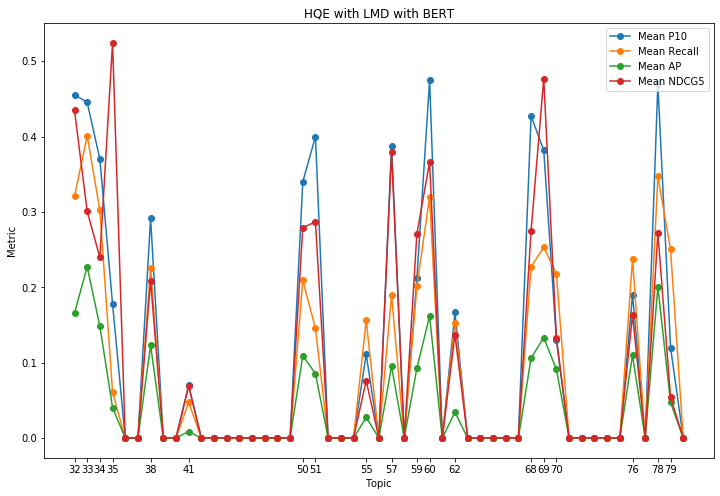

In [64]:
plt.figure(figsize=(12,8))
plt.plot(metrics_lmd_with_historical_expansion.index, metrics_lmd_with_historical_expansion["avg_p10"],"-o")
plt.plot(metrics_lmd_with_historical_expansion.index, metrics_lmd_with_historical_expansion["avg_recall"],"-o")
plt.plot(metrics_lmd_with_historical_expansion.index, metrics_lmd_with_historical_expansion["avg_ap"],"-o")
plt.plot(metrics_lmd_with_historical_expansion.index, metrics_lmd_with_historical_expansion["avg_ndcg5"],"-o")
plt.xticks(metrics_lmd_with_historical_expansion[metrics_lmd_with_historical_expansion["avg_p10"]!=0].index)
plt.ylabel("Metric")
plt.xlabel("Topic")
plt.title("HQE with LMD with BERT")
plt.legend(["Mean P10", "Mean Recall", "Mean AP","Mean NDCG5"])

topics_0 = [i for i in metrics_lmd_with_historical_expansion[metrics_lmd_with_historical_expansion["avg_p10"]==0].index]
print("Topics with metrics = 0:", topics_0)

Observing the plot above, we see that the metrics seem to have improved compared with the previous plots. We can compare the P@10 and the NDCG@5 of this method with the ones obtained for using only LMD + BERT.

Text(0.5, 0, 'Topic')

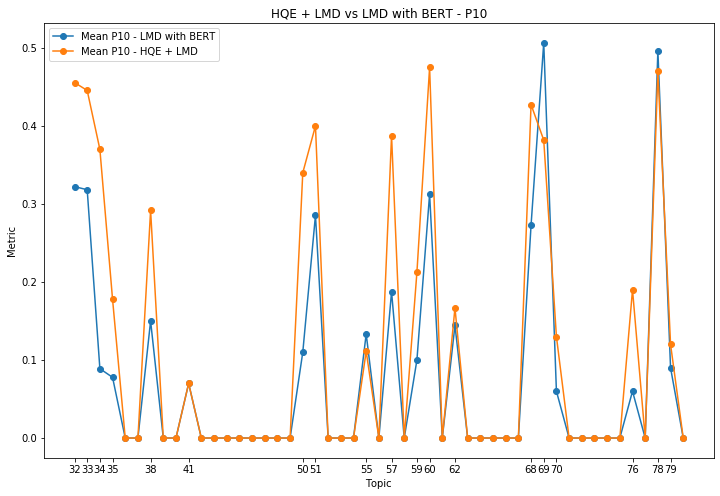

In [65]:
# Comparison of HQE + LMD with LMD with BERT (since it had the best results)
plt.figure(figsize=(12,8))
plt.plot(lmd_metrics.index, lmd_metrics["avg_p10"],"-o")
plt.plot(metrics_lmd_with_historical_expansion.index, metrics_lmd_with_historical_expansion["avg_p10"],"-o")
plt.legend(["Mean P10 - LMD with BERT", "Mean P10 - HQE + LMD"])
plt.xticks(metrics_lmd_with_historical_expansion[metrics_lmd_with_historical_expansion["avg_p10"]!=0].index)
plt.title("HQE + LMD vs LMD with BERT - P10")
plt.ylabel("Metric")
plt.xlabel("Topic")

Text(0.5, 0, 'Topic')

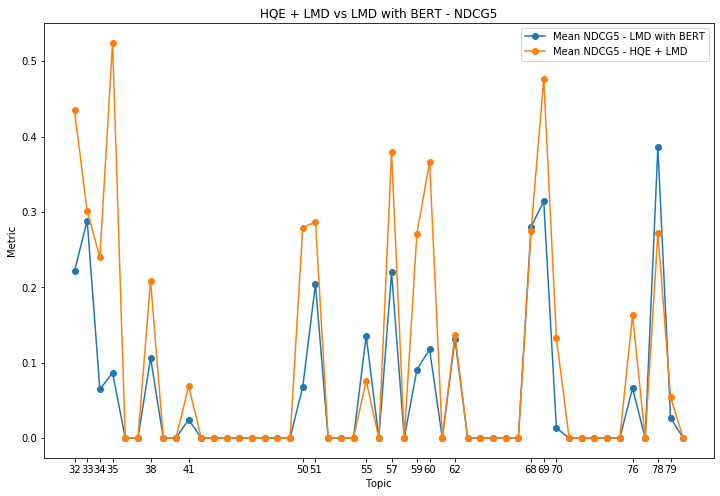

In [66]:
plt.figure(figsize=(12,8))
plt.plot(lmd_metrics.index, lmd_metrics["avg_ndcg5"],"-o")
plt.plot(metrics_lmd_with_historical_expansion.index, metrics_lmd_with_historical_expansion["avg_ndcg5"],"-o")
plt.legend(["Mean NDCG5 - LMD with BERT", "Mean NDCG5 - HQE + LMD"])
plt.xticks(metrics_lmd_with_historical_expansion[metrics_lmd_with_historical_expansion["avg_ndcg5"]!=0].index)
plt.title("HQE + LMD vs LMD with BERT - NDCG5")
plt.ylabel("Metric")
plt.xlabel("Topic")

Observing the two plots, we see that both P@10 and NDCG@5 improved with HQE in almost every topic.

We can also compute the total mean of these metrics, and compare them.

### Average Metrics Comparison

In [67]:
# Average metrics for LMD with BERT
lmd_metrics[lmd_metrics["avg_p10"]!=0].mean()

avg_p10       0.199269
avg_recall    0.142476
avg_ap        0.067060
avg_ndcg5     0.149745
dtype: float64

In [68]:
# Average metrics for HQE + RM3 with BERT
metrics_rm3_with_historical_expansion[metrics_rm3_with_historical_expansion["avg_p10"]!=0].mean()

avg_p10       0.103650
avg_recall    0.087802
avg_ap        0.033816
avg_ndcg5     0.071201
dtype: float64

In [69]:
# Average metrics for HQE + LMD with BERT
metrics_lmd_with_historical_expansion[metrics_lmd_with_historical_expansion["avg_p10"]!=0].mean()

avg_p10       0.295912
avg_recall    0.224534
avg_ap        0.105679
avg_ndcg5     0.260432
dtype: float64

Analyzing the results, we conclude that the best metrics were obtained with HQE + LMD with BERT. This method enabled us to obtain a P@10 of 0.296, a recall of 0.225, a MAP of 0.106 and a NDCG@5 of 0.260.

Again, comparing our results with the ones obtained in the *WaterlooClarke at the TREC 2019 Conversational Assistant Track* paper, our results are still worse. However, comparing the MAP we obtained with the MAP obtained by the teams reported in *CAsT 2019: The Conversational Assistance Track Overview*, our results were better than many teams, including SMNgate, ECNUICA_BERT, mpi-d5_union, MPmlp, SMNmlp, UMASS_DMN_V1, MPgate and galago_rel_q.

In conclusion, the best method to obtain good results in Conversational Search seems to be using Historical Query Expansion to provide context throughout each topic and then retrieving the top passages using LMD, computing the sentence pair embedding using BERT and multiplying the results by the weights computed using learning to rank.

To obtain better results, we suggest improving and fine tuning the RM3 implementation.